In [1]:
import numpy as np
import scipy as sc
import scipy.optimize
from warnings import warn
import sparse_ir
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
### System parameters
t    = 1      # hopping amplitude
W    = 8*t    # bandwidth
wmax = 10     # set wmax >= W

T    = 0.1    # temperature
beta = 1/T    # inverse temperature
n    = 0.85   # electron filling, here per spin per lattice site (n=1: half filling)
U    = 4      # Hubbard interaction

### Numerical parameters
nk1, nk2  = 24, 24    # number of k_points along one repiprocal crystal lattice direction k1 = kx, k2 = ky
nk        = nk1*nk2
IR_tol    = 1e-10     # desired accuary for l-cutoff of IR basis functions

In [3]:
#### Initiate fermionic and bosonic IR basis objects
IR_basis_set = sparse_ir.FiniteTempBasisSet(beta, wmax, eps=IR_tol)

class Mesh:
    """
    Holding class for k-mesh and sparsely sampled imaginary time 'tau' / Matsubara frequency 'iwn' grids.
    Additionally it defines the Fourier transform routines 'r <-> k'  and 'tau <-> l <-> wn'.
    """
    def __init__(self,IR_basis_set,nk1,nk2):
        self.IR_basis_set = IR_basis_set

        # generate k-mesh and dispersion
        self.nk1, self.nk2, self.nk = nk1, nk2, nk1*nk2
        self.k1, self.k2 = np.meshgrid(np.arange(self.nk1)/self.nk1, np.arange(self.nk2)/self.nk2)
        self.ek = -2*t*( np.cos(2*np.pi*self.k1) + np.cos(2*np.pi*self.k2) ).reshape(nk)

        # lowest Matsubara frequency index
        self.iw0_f = np.where(self.IR_basis_set.wn_f == 1)[0][0]
        self.iw0_b = np.where(self.IR_basis_set.wn_b == 0)[0][0]

        ### Generate a frequency-momentum grid for iw_n and ek (in preparation for calculating the Green function)
        # frequency mesh (for Green function)
        self.iwn_f = 1j * self.IR_basis_set.wn_f * np.pi * T
        self.iwn_f_ = np.tensordot(self.iwn_f, np.ones(nk), axes=0)

        # ek mesh
        self.ek_ = np.tensordot(np.ones(len(self.iwn_f)), self.ek, axes=0)

    def smpl_obj(self, statistics):
        """ Return sampling object for given statistic """
        smpl_tau = {'F': self.IR_basis_set.smpl_tau_f, 'B': self.IR_basis_set.smpl_tau_b}[statistics]
        smpl_wn  = {'F': self.IR_basis_set.smpl_wn_f,  'B': self.IR_basis_set.smpl_wn_b }[statistics]
        return smpl_tau, smpl_wn

    
    def tau_to_wn(self, statistics, obj_tau):
        """ Fourier transform from tau to iwn via IR basis """
        smpl_tau, smpl_wn = self.smpl_obj(statistics)

        obj_tau = obj_tau.reshape((smpl_tau.tau.size, self.nk1, self.nk2))
        obj_l   = smpl_tau.fit(obj_tau, axis=0)
        obj_wn  = smpl_wn.evaluate(obj_l, axis=0).reshape((smpl_wn.wn.size, self.nk))
        return obj_wn

    def wn_to_tau(self, statistics, obj_wn):
        """ Fourier transform from iwn to tau via IR basis """
        smpl_tau, smpl_wn = self.smpl_obj(statistics)

        obj_wn  = obj_wn.reshape((smpl_wn.wn.size, self.nk1, self.nk2))
        obj_l   = smpl_wn.fit(obj_wn, axis=0)
        obj_tau = smpl_tau.evaluate(obj_l, axis=0).reshape((smpl_tau.tau.size, self.nk))
        return obj_tau

    
    def k_to_r(self,obj_k):
        """ Fourier transform from k-space to real space """
        obj_k = obj_k.reshape(-1, self.nk1, self.nk2)
        obj_r = np.fft.fftn(obj_k,axes=(1,2))
        obj_r = obj_r.reshape(-1, self.nk)
        return obj_r

    def r_to_k(self,obj_r):
        """ Fourier transform from real space to k-space """
        obj_r = obj_r.reshape(-1, self.nk1, self.nk2)
        obj_k = np.fft.ifftn(obj_r,axes=(1,2))/self.nk
        obj_k = obj_k.reshape(-1, self.nk)
        return obj_k

In [4]:
class TPSCSolver:
    def __init__(self, mesh, U, n, U_sfc_tol=1e-12, verbose=True):
        """
        Solver class to calculate the TPSC method.
        After initializing the Solver by `solver = TPSCSolver(mesh, U, n, **kwargs)` it 
        can be run by `solver.solve()`.
        """
        ## set internal parameters for the solver
        self.U = U
        self.n = n
        self.mesh = mesh
        self.U_sfc_tol = U_sfc_tol
        self.verbose = verbose
        
        ## set initial Green function and irreducible susceptibility
        self.sigma = 0
        
        self.mu = 0
        self.mu_calc()
        
        self.gkio_calc(self.mu)
        self.grit_calc()
        self.ckio_calc()
        
        # determine critical U_crit = 1/max(chi0) as an upper bound to U_sp
        self.U_crit = 1/np.amax(self.ckio.real)
    
    
    #%%%%%%%%%%% Solving instance
    def solve(self):
        """
        Determine spin and charge vertex self-consistently from sum rules and calculate self-energy.
        """
        # determine spin vertex U_sp
        self.spin_vertex_calc()
        
        # set double occupancy from Kanamori-Bruckner screening
        self.docc_calc()
 
        # determine charge vertex U_ch
        self.charge_vertex_calc()
        
        # set spin and charge susceptibility
        self.chi_spin   = self.RPA_term_calc( self.U_sp)
        self.chi_charge = self.RPA_term_calc(-self.U_ch)

        # calculate interaction, self-energy and interacting Green function
        self.V_calc()
        self.sigma_calc()
        self.mu_calc()
        self.gkio_calc(self.mu)
    
    #%%%%%%%%%%% Calculation steps for self.energy
    def gkio_calc(self, mu):
        """ Calculate Green function G(iw,k) """
        self.gkio = (self.mesh.iwn_f_ - (self.mesh.ek_ - mu) - self.sigma)**(-1)

    def grit_calc(self):
        """ Calculate real space Green function G(tau,r) [for calculating chi0 and sigma] """
        # Fourier transform
        grit = self.mesh.k_to_r(self.gkio)
        self.grit = self.mesh.wn_to_tau('F', grit)

    def ckio_calc(self):
        """ Calculate irreducible susciptibility chi0(iv,q) """
        # fix: from v1 to v2
        ckio = - self.grit * self.grit[::-1, :]

        # Fourier transform
        ckio = self.mesh.r_to_k(ckio)
        self.ckio = self.mesh.tau_to_wn('B', ckio)

    def V_calc(self):
        """ Calculate interaction V(tau,r) from RPA-like spin and charge susceptibility """
        V = self.U/4 * (3*self.U_sp*self.chi_spin + self.U_ch*self.chi_charge)
        # Constant Hartree Term V ~ U needs to be treated extra, since it cannot be modeled by the IR basis compactly.
        # In the single-band case, the Hartree term can be absorbed into the chemical potential.

        # Fourier transform
        V = self.mesh.k_to_r(V)
        self.V = self.mesh.wn_to_tau('B', V)

    def sigma_calc(self):
        """ Calculate self-energy Sigma(iwn,k) """
        sigma = self.V * self.grit
    
        # Fourier transform
        sigma = self.mesh.r_to_k(sigma)
        self.sigma = self.mesh.tau_to_wn('F', sigma)


    #%%%%%%%%%%% Determining spin and charge vertex
    def RPA_term_calc(self, U):
        """ Set RPA-like susceptibility """
        chi_RPA = self.ckio / (1 - U*self.ckio)
        return chi_RPA     
    
    def chi_qtrace_calc(self, U):
        """ Calculate (iv_m, q) trace of chi_RPA term """
        # chi_qtrace = sum_(m,q) chi(iv_m,q)
        chi_RPA = self.RPA_term_calc(U)
        chi_trace = np.sum(chi_RPA, axis=1)/self.mesh.nk
        chi_trace_l  = self.mesh.IR_basis_set.smpl_wn_b.fit(chi_trace)
        chi_trace = self.mesh.IR_basis_set.basis_b.u(0)@chi_trace_l
        return chi_trace.real
    
    def docc_calc(self):
        """ Calculate double occupancy from Kanamori-Bruckner type screening """
        self.docc = 0.25 * self.U_sp/self.U * self.n**2
    
    def spin_vertex_calc(self):
        """ Determine U_sp self-consistently from local sum rule """
        # interval [U_a, U_b] for root finding
        U_a = 0
        U_b = np.floor(self.U_crit*100)/100
        
        chi_trace = self.chi_qtrace_calc
        sfc_eq = lambda U_sp : 2*chi_trace(U_sp) - self.n + 0.5*(U_sp/self.U)*self.n**2

        if sfc_eq(U_b) > 0:        
            self.U_sp = sc.optimize.brentq(sfc_eq, U_a, U_b, rtol = self.U_sfc_tol)
            print("Setting U_sp = {}".format(self.U_sp))
        else:
            print("Error")
            warn("System underwent phase transition, U^sp > U_crit = {}! U is too large or T too low for given doping.".format(self.U_crit))
    
    def charge_vertex_calc(self):
        """ Determine U_ch self-consistently from local sum rule """
        # interval [U_a, U_b] for root finding
        U_a = 0
        U_b = 100
        
        chi_trace = self.chi_qtrace_calc
        sfc_eq = lambda U_ch : 2*chi_trace(-U_ch) - self.n + (1 - 2*self.docc)*self.n**2

        self.U_ch = sc.optimize.brentq(sfc_eq, U_a, U_b, rtol = self.U_sfc_tol)

        
    #%%%%%%%%%%% Setting chemical potential mu
    def calc_electron_density(self, mu):
        """ Calculate chemical potential mu from Green function """
        self.gkio_calc(mu)
        gio  = np.sum(self.gkio,axis=1)/self.mesh.nk
        g_l  = self.mesh.IR_basis_set.smpl_wn_f.fit(gio)
        g_tau0 = self.mesh.IR_basis_set.basis_f.u(0)@g_l
    
        n  = 1 + np.real(g_tau0)
        n  = 2*n #for spin
        return n

    def mu_calc(self):
        """ Find chemical potential for a given filling n0 via brentq root finding algorithm """
        n_calc = self.calc_electron_density
        n0 = self.n
        f  = lambda mu : n_calc(mu) - n0

        self.mu = sc.optimize.brentq(f, np.amax(self.mesh.ek)*3, np.amin(self.mesh.ek)*3)

In [5]:
# initialize calculation
IR_basis_set = sparse_ir.FiniteTempBasisSet(beta, wmax, eps=IR_tol)
mesh = Mesh(IR_basis_set, nk1, nk2)
solver = TPSCSolver(mesh, U, n)

# perform TPSC calculation
solver.solve()

Setting U_sp = 2.1011348344804945

<>:4: SyntaxWarning: invalid escape sequence '\p'
<>:6: SyntaxWarning: invalid escape sequence '\p'
<>:9: SyntaxWarning: invalid escape sequence '\o'
<>:4: SyntaxWarning: invalid escape sequence '\p'
<>:6: SyntaxWarning: invalid escape sequence '\p'
<>:9: SyntaxWarning: invalid escape sequence '\o'
/var/folders/1t/fxgqx0n17z33mplwpw4n1d8r0000gn/T/ipykernel_57484/2614448632.py:4: SyntaxWarning: invalid escape sequence '\p'
  ax.set_xlabel('$k_x/\pi$')
/var/folders/1t/fxgqx0n17z33mplwpw4n1d8r0000gn/T/ipykernel_57484/2614448632.py:6: SyntaxWarning: invalid escape sequence '\p'
  ax.set_ylabel('$k_y/\pi$')
/var/folders/1t/fxgqx0n17z33mplwpw4n1d8r0000gn/T/ipykernel_57484/2614448632.py:9: SyntaxWarning: invalid escape sequence '\o'
  ax.set_title('Re $G(k,i\omega_0)$')


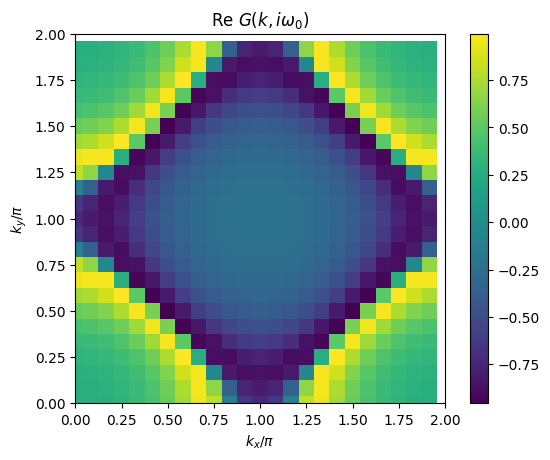

In [6]:
# plot 2D k-dependence of lowest Matsubara frequency of e.g. green function
plt.pcolormesh(2*mesh.k1.reshape(nk1,nk2), 2*mesh.k2.reshape(nk1,nk2), np.real(solver.gkio[mesh.iw0_f].reshape(mesh.nk1,mesh.nk2)), shading='auto')
ax = plt.gca()
ax.set_xlabel('$k_x/\pi$')
ax.set_xlim([0,2])
ax.set_ylabel('$k_y/\pi$')
ax.set_ylim([0,2])
ax.set_aspect('equal')
ax.set_title('Re $G(k,i\omega_0)$')
plt.colorbar()
plt.show()

<>:4: SyntaxWarning: invalid escape sequence '\p'
<>:6: SyntaxWarning: invalid escape sequence '\p'
<>:9: SyntaxWarning: invalid escape sequence '\S'
<>:4: SyntaxWarning: invalid escape sequence '\p'
<>:6: SyntaxWarning: invalid escape sequence '\p'
<>:9: SyntaxWarning: invalid escape sequence '\S'
/var/folders/1t/fxgqx0n17z33mplwpw4n1d8r0000gn/T/ipykernel_57484/1524884887.py:4: SyntaxWarning: invalid escape sequence '\p'
  ax.set_xlabel('$k_x/\pi$')
/var/folders/1t/fxgqx0n17z33mplwpw4n1d8r0000gn/T/ipykernel_57484/1524884887.py:6: SyntaxWarning: invalid escape sequence '\p'
  ax.set_ylabel('$k_y/\pi$')
/var/folders/1t/fxgqx0n17z33mplwpw4n1d8r0000gn/T/ipykernel_57484/1524884887.py:9: SyntaxWarning: invalid escape sequence '\S'
  ax.set_title('Im $\Sigma(k,i\omega_0)$')


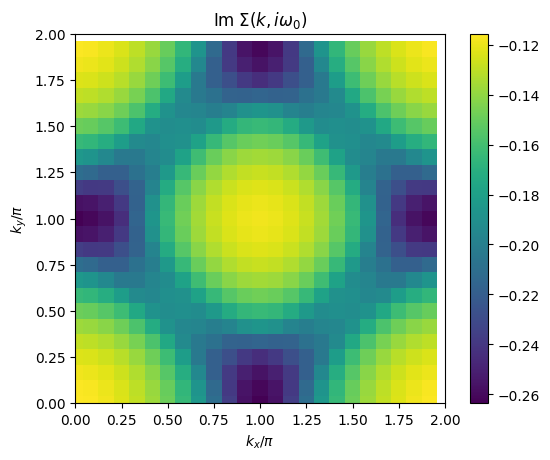

In [7]:
# plot 2D k-dependence of lowest Matsubara frequency of e.g. self-energy
plt.pcolormesh(2*mesh.k1.reshape(nk1,nk2), 2*mesh.k2.reshape(nk1,nk2), np.imag(solver.sigma[mesh.iw0_f].reshape(mesh.nk1,mesh.nk2)), shading='auto')
ax = plt.gca()
ax.set_xlabel('$k_x/\pi$')
ax.set_xlim([0,2])
ax.set_ylabel('$k_y/\pi$')
ax.set_ylim([0,2])
ax.set_aspect('equal')
ax.set_title('Im $\Sigma(k,i\omega_0)$')
plt.colorbar()
plt.show()

<>:4: SyntaxWarning: invalid escape sequence '\p'
<>:6: SyntaxWarning: invalid escape sequence '\p'
<>:9: SyntaxWarning: invalid escape sequence '\c'
<>:4: SyntaxWarning: invalid escape sequence '\p'
<>:6: SyntaxWarning: invalid escape sequence '\p'
<>:9: SyntaxWarning: invalid escape sequence '\c'
/var/folders/1t/fxgqx0n17z33mplwpw4n1d8r0000gn/T/ipykernel_57484/2686374420.py:4: SyntaxWarning: invalid escape sequence '\p'
  ax.set_xlabel('$k_x/\pi$')
/var/folders/1t/fxgqx0n17z33mplwpw4n1d8r0000gn/T/ipykernel_57484/2686374420.py:6: SyntaxWarning: invalid escape sequence '\p'
  ax.set_ylabel('$k_y/\pi$')
/var/folders/1t/fxgqx0n17z33mplwpw4n1d8r0000gn/T/ipykernel_57484/2686374420.py:9: SyntaxWarning: invalid escape sequence '\c'
  ax.set_title('$\chi_{\mathrm{sp}}(k,i\nu_0)$')


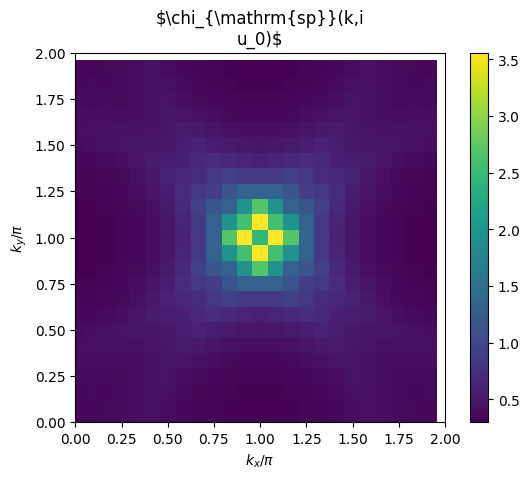

In [8]:
# plot 2D k-dependence of lowest Matsubara frequency of e.g. chi_spin
plt.pcolormesh(2*mesh.k1.reshape(nk1,nk2), 2*mesh.k2.reshape(nk1,nk2), np.real(solver.chi_spin[mesh.iw0_b].reshape(mesh.nk1,mesh.nk2)), shading='auto')
ax = plt.gca()
ax.set_xlabel('$k_x/\pi$')
ax.set_xlim([0,2])
ax.set_ylabel('$k_y/\pi$')
ax.set_ylim([0,2])
ax.set_aspect('equal')
ax.set_title('$\chi_{\mathrm{sp}}(k,i\nu_0)$')
plt.colorbar()
plt.show()

Initialization...

<>:47: SyntaxWarning: invalid escape sequence '\m'
<>:48: SyntaxWarning: invalid escape sequence '\m'
<>:47: SyntaxWarning: invalid escape sequence '\m'
<>:48: SyntaxWarning: invalid escape sequence '\m'
/var/folders/1t/fxgqx0n17z33mplwpw4n1d8r0000gn/T/ipykernel_57484/1554326033.py:47: SyntaxWarning: invalid escape sequence '\m'
  plt.plot(U_array, U_ch_array, '-', label='$U_{\mathrm{ch}}$')
/var/folders/1t/fxgqx0n17z33mplwpw4n1d8r0000gn/T/ipykernel_57484/1554326033.py:48: SyntaxWarning: invalid escape sequence '\m'
  plt.plot(U_array, U_sp_array, '-', label='$U_{\mathrm{sp}}$')


Start TPSC loop...

Setting U_sp = 0.009988853647935142

Setting U_sp = 0.10844539767304137

Setting U_sp = 0.20462542385301566

Setting U_sp = 0.2984789555706955

Setting U_sp = 0.38995933428732577

Setting U_sp = 0.4790237958387998

Setting U_sp = 0.5656340453556727

Setting U_sp = 0.6497568174661893

Setting U_sp = 0.731364407280038

Setting U_sp = 0.8104351570179269

Setting U_sp = 0.8869538831669794

Setting U_sp = 0.9609122297786352

Setting U_sp = 1.0323089350574113

Setting U_sp = 1.1011500006251835

Setting U_sp = 1.167448755793373

Setting U_sp = 1.2312258126104405

Setting U_sp = 1.2925089112258377

Setting U_sp = 1.351332658975074

Setting U_sp = 1.407738170304622

Setting U_sp = 1.4617726179870079

Setting U_sp = 1.5134887088267046

Setting U_sp = 1.5629440990795302

Setting U_sp = 1.6102007660186637

Setting U_sp = 1.6553243524630132

Setting U_sp = 1.698383500685407

Setting U_sp = 1.7394491910380925

Setting U_sp = 1.7785940990080047

Setting U_sp = 1.8158919824012563

Setting U_sp = 1.8514171081164592

Setting U_sp = 1.8852437256509629

Setting U_sp = 1.9174455922237692

Setting U_sp = 1.9480955522975565

Setting U_sp = 1.9772651724145571

Setting U_sp = 2.005024430672467

Setting U_sp = 2.031441458877369

Setting U_sp = 2.0565823344196947

Setting U_sp = 2.0805109182034855

Setting U_sp = 2.103288734516636

Setting U_sp = 2.124974888453772

Setting U_sp = 2.145626016482253

Setting U_sp = 2.165296265792269

Setting U_sp = 2.1840372982535525

Setting U_sp = 2.201898315103475

Setting U_sp = 2.218926098746976

Setting U_sp = 2.2351650684335627

Setting U_sp = 2.250657346902997

Setting U_sp = 2.265442835444129

Setting U_sp = 2.2795592951417754

Setting U_sp = 2.2930424324008554

Setting U_sp = 2.3059259871201343

Setting U_sp = 2.3182418221686993

Finished. Plotting now.

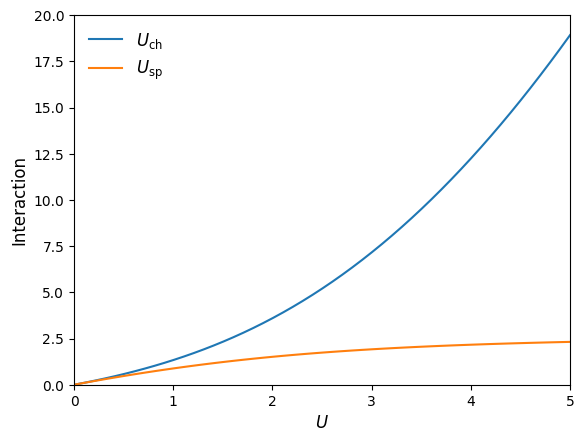

In [9]:
#%%%%%%%%%%%%%%% Parameter settings
print('Initialization...')
# system parameters
t = 1         # hopping amplitude
n = 1         # electron filling, here per spin per lattice site (n=1: half filling)
T = 0.4       # temperature
beta =1/T
U_array = np.linspace(1e-2,5,51)  # Hubbard interaction

W    = 8*t    # bandwidth
wmax = 10     # set wmax >= W

# numerical parameters
nk1, nk2  = 24, 24    # k-mesh sufficiently dense!
nk        = nk1*nk2
IR_tol    = 1e-8      # desired accuary for l-cutoff of IR basis functions


# initialize meshes
IR_basis_set = sparse_ir.FiniteTempBasisSet(beta, wmax, eps=IR_tol)
mesh = Mesh(IR_basis_set, nk1, nk2)

# set initial self_energy - will be set to previous calculation step afterwards
sigma_init = 0

# empty arrays for results later
U_sp_array = np.empty((len(U_array)))
U_ch_array = np.empty((len(U_array)))


#%%%%%%%%%%%%%%% Calculations for different U values
print("Start TPSC loop...")
for U_it, U in enumerate(U_array):
    #print("Now: U = {:.1f}".format(U))
    
    # TPSC solver
    solver = TPSCSolver(mesh, U, n, verbose=False)
    solver.solve()
    
    # save data for plotting
    U_sp_array[U_it] = solver.U_sp
    U_ch_array[U_it] = solver.U_ch
print("Finished. Plotting now.")


#%%%%%%%%%%%%%%%% Plot results
plt.plot(U_array, U_ch_array, '-', label='$U_{\mathrm{ch}}$')
plt.plot(U_array, U_sp_array, '-', label='$U_{\mathrm{sp}}$')
ax = plt.gca()
ax.set_xlabel('$U$', fontsize=12)
ax.set_xlim([0,5])
ax.set_ylabel('Interaction', fontsize=12)
ax.set_ylim([0,20])
ax.legend(frameon=False, fontsize=12)